In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from cv_error import *
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-darkgrid')

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
df.drop(['zipcode', 'id', 'date'], axis=1, inplace=True)

In [4]:
print("Número de filas: {}".format(df.shape[0]))
print("Número de columnas: {}".format(df.shape[1]))

Número de filas: 21613
Número de columnas: 18


In [5]:
print("Ver la naturaleza de los atributos")
df.info()

Ver la naturaleza de los atributos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.0 MB


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['price'] = np.log(df['price'])

Text(0.5, 1.0, 'Histograma logaritmo del Precio')

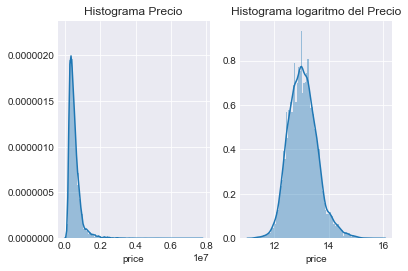

In [7]:
fig, ax = plt.subplots(1, 2)
sns.distplot(df['price'], bins='fd', ax=ax[0])
ax[0].set_title('Histograma Precio')
sns.distplot(df_scaled['price'], bins='fd', ax=ax[1])
ax[1].set_title('Histograma logaritmo del Precio')

In [8]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error

In [9]:
X = df_scaled.iloc[:, 1:]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['price']
X_train, X_test, y_train, y_test = train_test_split(X,
y, test_size=.33, random_state=63)

In [10]:
y_train.shape

(14480,)

In [11]:
alphas = np.logspace(0, 7, base=10)

In [12]:
names_regressors = X_train.columns

In [13]:
coefs_ridge, cv_err_ridge = [] , []
model_ridge = Ridge(fit_intercept=True)

for a in alphas:
    model_ridge.set_params(alpha=a)
    model_ridge.fit(X_train, y_train)
    coefs_ridge.append(model_ridge.coef_)
    dummy, cv_err_estimates = cv_error(X_train, y_train, k=10, method='ridge', alpha=a)
    cv_err_ridge.append(np.mean(cv_err_estimates))
    

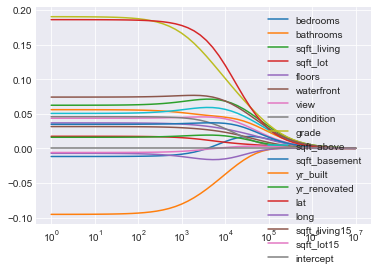

In [14]:
ax = plt.gca()

for y_arr, label in zip(np.squeeze(coefs_ridge).T, names_regressors):
    plt.plot(alphas, y_arr, label=label)

ax.set_xscale('log')
plt.legend(loc=1)

### Eligiendo Hiperparámetros

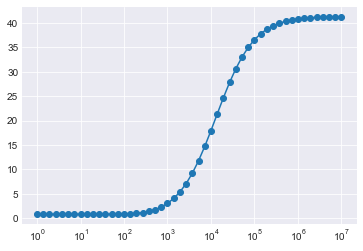

In [15]:
ax = plt.gca()
plt.plot(alphas, np.sqrt(cv_err_ridge), 'o-')
ax.set_xscale('log')

In [16]:
ridge_cv = RidgeCV(cv=10)
model_ridge = ridge_cv.fit(X_train, y_train)
model_ridge.alpha_

10.0

In [17]:
model_ridge.coef_

array([-0.01152051,  0.05594325,  0.06247254,  0.01758403,  0.03688535,
        0.03158963,  0.04366224,  0.04588752,  0.18988215,  0.05064816,
        0.03487782, -0.09486206,  0.01621742,  0.18580857, -0.00701508,
        0.07418383, -0.00576774,  0.        ])

In [18]:
from sklearn.metrics import r2_score

print(r2_score(model_ridge.predict(X_test), y_test))

0.6988363623658158


Coeficiente de determinacion: 70 porciento en predecir la varianza de los puntajes del vector objetivo

Lasso permite seleccionar y regularizar atributos

### Regresion Lasso

In [19]:
alphas = np.logspace(0, -3, base=10)

In [20]:
coefs_lasso, cv_err_lasso = [] , []
model_lasso = Lasso(fit_intercept=True)

for a in alphas:
    model_lasso.set_params(alpha=a)
    model_lasso.fit(X_train, y_train)
    coefs_lasso.append(model_lasso.coef_)
    dummy, cv_err_estimates = cv_error(X_train, y_train, k=10, method='lasso', alpha=a)
    cv_err_lasso.append(np.mean(cv_err_estimates))


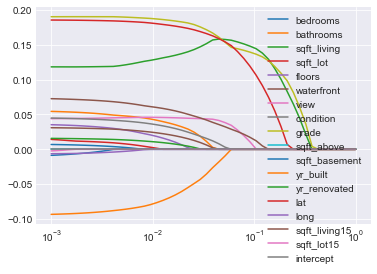

In [21]:
ax = plt.gca()

for y_arr, label in zip(np.squeeze(coefs_lasso).T, names_regressors):
    plt.plot(alphas, y_arr, label=label)

ax.set_xscale('log')
plt.legend(loc=1)

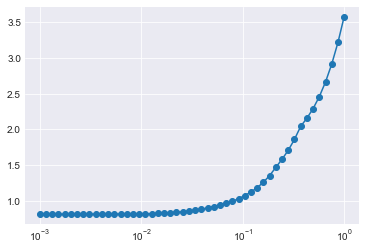

In [22]:
ax = plt.gca()
plt.plot(alphas, np.sqrt(cv_err_lasso), 'o-')
ax.set_xscale('log')

In [23]:
lasso_cv = LassoCV()
model_lasso = lasso_cv.fit(X_train, y_train)

In [24]:
model_lasso.alpha_

0.0007063178420188403

In [25]:
model_lasso.coef_

array([-0.00950177,  0.054879  ,  0.11831375,  0.015189  ,  0.035774  ,
        0.03115456,  0.04389359,  0.0451542 ,  0.19025511,  0.        ,
        0.00719784, -0.09386775,  0.01582708,  0.18563712, -0.00654469,
        0.07312149, -0.00334994,  0.        ])

In [26]:
print(r2_score(model_lasso.predict(X_test), y_test))

0.6971593291452678


### Elastic Net

In [27]:
from sklearn.linear_model import ElasticNet, ElasticNetCV


In [45]:
alphas = np.logspace(0, -3, base=10)

In [46]:
coefs_elastic_net, cv_err_elastic_net = [] , []
model_elastic_net = ElasticNet(fit_intercept=True)

for a in alphas:
    model_elastic_net.set_params(alpha=a)
    model_elastic_net.fit(X_train, y_train)
    coefs_elastic_net.append(model_elastic_net.coef_)
    dummy, cv_err_estimates = cv_error(X_train, y_train, k=10, method='enet', alpha=a)
    cv_err_elastic_net.append(np.mean(cv_err_estimates))


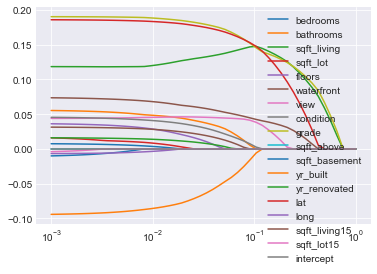

In [47]:
ax = plt.gca()

for y_arr, label in zip(np.squeeze(coefs_elastic_net).T, names_regressors):
    plt.plot(alphas, y_arr, label=label)

ax.set_xscale('log')
plt.legend(loc=1)

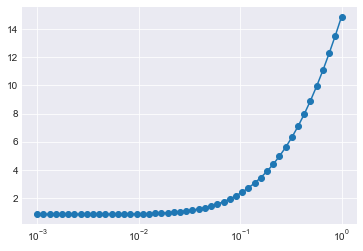

In [48]:
ax = plt.gca()
plt.plot(alphas, np.sqrt(cv_err_elastic_net), 'o-')
ax.set_xscale('log')

In [41]:
elastic_cv = ElasticNetCV(cv=10)
model_elastic_net = elastic_cv.fit(X_train, y_train)
model_elastic_net.alpha_


0.0007538811768978494

In [42]:
model_elastic_net.coef_

array([-0.01041958,  0.05539722,  0.11833812,  0.0163107 ,  0.03631222,
        0.03135989,  0.04378358,  0.04549291,  0.19009754,  0.        ,
        0.00753177, -0.09432999,  0.01601096,  0.18570418, -0.00675886,
        0.07366047, -0.00447206,  0.        ])

In [44]:
r2_score(model_elastic_net.predict(X_test), y_test)

0.6979256636726777